In [2]:
## Importing Libraries ## 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline
from scipy.optimize import minimize
import time

In [3]:
## This cell defines our Poission Process, Customer, and Customer List Classes ##

#############################
class PoissonProcess():
    def __init__(self, lam, T):
        self.lam = lam
        self.T = T
        self.simulate()

        
    def simulate(self, method='inter_arrival_time'):
        if method == 'inter_arrival_time':
            N = int(self.lam * self.T * 1.3)
            inter_ls = np.random.exponential(1/self.lam, size=N)
            arrival_time_ls = np.cumsum(inter_ls)
            self.arrival_time_ls = arrival_time_ls[arrival_time_ls <= self.T]
        if method == 'uniformity_property':
            N = np.random.poisson(self.T * self.lam)
            arrival_time_ls = np.random.uniform(0, self.T, size=N)
            self.arrival_time_ls = np.sort(arrival_time_ls)

            
    def get_arrival_time(self):
        return self.arrival_time_ls

    
    def print_parameter(self):
        print('lambda = {}, T = {}'.format(self.lam, self.T))

        
    def N_t(self, t):
        assert t >= 0
        assert t <= self.T
        if t == 0:
            return 0
        else:
            return np.argmax(self.arrival_time_ls > t)

        
    def plot_N_t(self, color='r',alpha=1):
        positive_inf = max(self.arrival_time_ls) * 1.2
        negative_inf = - max(self.arrival_time_ls) * 0.1
        n_arrival = len(self.arrival_time_ls)
        x_ls = np.concatenate([[negative_inf, 0], np.repeat(self.arrival_time_ls,2), [positive_inf]])
        y_ls = np.concatenate([[0], np.repeat(np.arange(n_arrival + 1),2)])
        plt.plot(x_ls, y_ls, c=color, alpha=alpha)        

#############################        
class Customer():
    def __init__(self, arrival_time=0, ctype='normal',wait_time=None):
        self.arrival_time = arrival_time
        self.ctype = ctype
        self.wait_time = wait_time
        
        
    def abandon_prob(self,prev_cust_wait):
        
        abandon_probs = {"<40":.005, ">=40<50":0.015, ">=50<60":0.03, ">=60<75":0.08, ">=75<90":0.1,
                         ">=90<105":0.1, ">=105<120":0.1, ">=120<180":0.1, ">=180":0.15,
                        }
        ### 170 is <<< 1800 so so our approximation the people in the line is okay
        if prev_cust_wait == 0:
            abandon_prob = 0
        elif prev_cust_wait<(40/60):
            abandon_prob = abandon_probs["<40"]
        elif prev_cust_wait>=(40/60) and prev_cust_wait<(50/60):
            abandon_prob = abandon_probs[">=40<50"]
        elif prev_cust_wait>=(50/60) and prev_cust_wait<(60/60):
            abandon_prob = abandon_probs[">=50<60"]
        elif prev_cust_wait>=(60/60) and prev_cust_wait<(75/60):
            abandon_prob = abandon_probs[">=60<75"]
        elif prev_cust_wait>=(75/60) and prev_cust_wait<(90/60):
            abandon_prob = abandon_probs[">=75<90"]
        elif prev_cust_wait>=(90/60) and prev_cust_wait<(105/60):
            abandon_prob = abandon_probs[">=90<105"]    
        elif prev_cust_wait>=(105/60) and prev_cust_wait<(120/60):
            abandon_prob = abandon_probs[">=105<120"]  
        elif prev_cust_wait>=(120/60) and prev_cust_wait<(180/60):
            abandon_prob = abandon_probs[">=120<180"]
        elif prev_cust_wait>=(180/60):
            abandon_prob = abandon_probs[">=180"]
            
        return abandon_prob
    
    
#############################
class Customer_ls():
    empty = ()

    def __init__(self, customer_ls=np.array([])):
        self.customer_ls = np.array(customer_ls)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in customer_ls])]
        self.next = None if not customer_ls else self.customer_ls[0]

        
    def __len__(self):
        return len(self.customer_ls)
        
        
    def next_exits(self):
        if len(self)==1:
            next_cust, self.customer_ls = self.customer_ls[0], np.array([])
            self.next = None
        else:
            next_cust, self.customer_ls = self.customer_ls[0], self.customer_ls[1:]
            self.next = self.customer_ls[0]
        return next_cust
    
    
    def add_to_sort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
    
    
    def add_to_nosort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.next = self.customer_ls[0]
    
    
    def sort(self):
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
        

#############################

___

## Model #3

In [4]:
## Loading Speed Factor Function ## 
def speed_factor(proportion_express): 
    factor = -0.5*proportion_express + 1

        #factor = 1 - 0.8*np.sqrt(proportion_express)
    return factor

In [5]:
## ONE DAY FUNCTION FOR MODEL #3 ##

## The cell contains a function to simulate a single day of the queueing system ##

def one_day_express(arrival_ls):
    
    #### FOR TUNING ####
    ExpressPriority = 1.0
    express_prop = 0.15
    express_abandon_prob = 0.15
    ####################
    
    customer_arrivals = [Customer(arr) for arr in arrival_ls]
    customer_arrivals = Customer_ls(customer_arrivals)

    NormalQueue, ExpressQueue, cust_output= Customer_ls(), Customer_ls(), Customer_ls()
    
    switched_11, switched_1 = False, False
    capacity_8, capacity_11, capacity_1 = 136, 170, 204
    train_capacity = capacity_8
    
    train_finish_time, prev_wait_time = 0, 0
    time = 0
    while len(customer_arrivals) > 0 or len(NormalQueue) > 0 or len(ExpressQueue) > 0:

        next_arr = customer_arrivals.next
        
        ## FIRST CAR DOESN"T LEAVE TILL FULL ##
        if train_finish_time == 0 and len(NormalQueue)<train_capacity:
            if np.random.binomial(n=1,p=express_prop):
                new_arrival = customer_arrivals.next_exits()
                new_arrival.arrival_time += np.random.uniform(0.5,1.5)
                new_arrival.ctype = "express"
                customer_arrivals.add_to_sort(new_arrival)
            else:
                new_arrival = customer_arrivals.next_exits()
                NormalQueue.add_to_nosort(new_arrival)
            
            if len(NormalQueue)==train_capacity:
                train_finish_time = NormalQueue.customer_ls[-1].arrival_time
        
        ## ARRIVAL TO SYSTEM ##
        elif len(customer_arrivals)>0 and (len(NormalQueue)+len(ExpressQueue)==0 or next_arr.arrival_time<train_finish_time):
            
            if next_arr.arrival_time>time:
                customer_arrivals.sort()
                time+=0.4
                next_arr = customer_arrivals.next
            
            ## EXPRESS ARRIVAL
            if next_arr.ctype == "express":
                new_arrival = customer_arrivals.next_exits()
                ExpressQueue.add_to_nosort(new_arrival)
            
            ## NORMAL ARRIVAL ##
            elif next_arr.ctype == "normal":
                if next_arr.arrival_time <= 10.5 and np.random.binomial(n=1,p=express_prop):
                    new_arrival = customer_arrivals.next_exits()
                    new_arrival.arrival_time += np.random.uniform(0.5,1.5)
                    new_arrival.ctype = "express"
                    customer_arrivals.add_to_nosort(new_arrival)
                else:
                    new_arrival = customer_arrivals.next_exits()
                    NormalQueue.add_to_nosort(new_arrival)
        
        ## SEND A TRAIN ##
        else:
            if train_finish_time > 3 and not switched_11: 
                train_capacity = capacity_11
                switched_11 = True
            elif train_finish_time > 5 and not switched_1:
                train_capacity = capacity_1
                switched_1 = True
                
            train_max = min(train_capacity,len(NormalQueue)+len(ExpressQueue))
            rider_types = np.array([])
                
            train_count = 0
            last_abandon = False
            load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority])
            while train_count < train_max:
                
                ## EXIT IF BOTH QUEUES ARE EMPTY ##
                if len(ExpressQueue)==0 and len(NormalQueue)==0:
                    train_max = train_count
                    
                ## PROCESS THE NEXT CUSTOMER FROM EITHER EXPRESS OR NORMAL ##
                else:
                    load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority]) if not(last_abandon) else load_next
                    
                    ## NEXT IS EXPRESS ##
                    if len(ExpressQueue)!=0 and load_next=='express':
                        next_served = ExpressQueue.next_exits()
                        abandon_prob = express_abandon_prob
    
                    ## NEXT IS NORMAL ##
                    elif (len(ExpressQueue)==0 and len(NormalQueue)>0) or (len(NormalQueue)!=0 and load_next=='normal'):
                        next_served = NormalQueue.next_exits()
                        abandon_prob = next_served.abandon_prob(prev_wait_time)
                        
                    ## NO ABANDON ##
                    if np.random.binomial(n=1,p=1-abandon_prob):
                        new_wait_time = max(0,train_finish_time-next_served.arrival_time)
                        next_served.wait_time = new_wait_time
                        cust_output.add_to_nosort(next_served)
                        prev_wait_time = new_wait_time
                        train_count += 1
                        last_abandon=False
                        rider_types = np.append(rider_types, next_served.ctype)
                    
                    ## ABANDON ##
                    else:
                        next_served.wait_time = -999
                        cust_output.add_to_nosort(next_served)
                        last_abandon=True
            
            
            
            ## SPEED FACTOR AND SERVICE TIME ##
            proportion_express = 0 if len(rider_types)==0 else np.count_nonzero(rider_types == 'express') / len(rider_types)
            factor = speed_factor(proportion_express)
            
            load_min, load_max = 0.5/60, 1./60
            unload_min, unload_max = 0.25/60, 0.75/60
            
            load_time = factor * np.random.uniform(load_min, load_max)
            unload_time = np.random.uniform(unload_min, unload_max)
            service_time = load_time + 3./60 + unload_time
            
            train_finish_time = train_finish_time + service_time
    
    return cust_output

In [117]:
## SIMULATING w/ MODEL #3 AND OUTPUT TABLE ## 

# Simulating Trials 
trials = 30
df = pd.DataFrame()
for i in np.arange(0, trials): 
    
    # Loading Arrival Data & Simulating 30 days
    arrival_ls = np.genfromtxt('data/day' + str(i+1) + '_arrivals.csv')[1:]
    customers = one_day_express(arrival_ls).customer_ls
    
    # Creating Data Frame
    data = {
        'day' : i*np.ones(len(arrival_ls)).astype(int),
        'arrival' : [customer.arrival_time for customer in customers], 
        'wait' : [60*customer.wait_time for customer in customers],
    'Customer Type' : [customer.ctype for customer in customers]}
    df = df.append(pd.DataFrame(data))

# Cleaning the Data Frame
df['arrival hour'] = df['arrival'].astype(str).str.split('.').apply(lambda x: x[0]).astype(int)
abandoned_df = df[df['wait'] < 0]
df = df[df['wait'] >= 0]
df = df.replace( {'normal' : 'Standard', 
                 'express' : 'Express'})

In [118]:
df

,day,arrival,wait,Customer Type,arrival hour
0,0,0.006,10.260000,Standard,0
1,0,0.006,10.260000,Standard,0
2,0,0.007,10.200000,Standard,0
3,0,0.009,10.080000,Standard,0
4,0,0.012,9.900000,Standard,0
...,...,...,...,...,...
32519,29,11.998,10.870627,Standard,11
32520,29,11.998,10.870627,Standard,11
32521,29,11.998,10.870627,Standard,11
32522,29,11.998,10.870627,Standard,11


In [120]:
df.groupby('arrival hour').count()['arrival']

arrival hour
0     40416
1     68870
2     85365
3     90478
4     90701
5     88664
6     87136
7     86121
8     84359
9     79789
10    73695
11    51743
Name: arrival, dtype: int64

In [125]:
#Output Table for Model #3

# Separating the DF into separate Data Frames for Standard & Express
standard_df = df[df['Customer Type'] == 'Standard']
express_df = df[df['Customer Type'] == 'Express']
standard_abandoned_df = abandoned_df[abandoned_df['Customer Type'] == 'Standard']
express_abandoned_df = abandoned_df[abandoned_df['Customer Type'] == 'Express']

# Aggregate Groupings 
day_grouped = df.groupby('day').count()['arrival']
hr_grouped = df.groupby('arrival hour').count()['arrival']
abandon_percents = 100* (abandoned_df.groupby('day').size() / df.groupby('day').size())

# Standard Groupings 
standard_day_grouped = standard_df.groupby('day').count()['arrival']
standard_hr_grouped = standard_df.groupby('arrival hour').count()['arrival']
standard_abandon_percents = 100* (standard_abandoned_df.groupby('day').size() / standard_df.groupby('day').size())

# Express Groupings
express_day_grouped = express_df.groupby('day').count()['arrival']
express_hr_grouped = express_df.groupby('arrival hour').count()['arrival']
express_abandon_percents = 100* (express_abandoned_df.groupby('day').size() / express_df.groupby('day').size())

stats = [np.min, np.mean, np.max]

# Aggregate Columns
agg_one = [np.round(stat(df['wait']), 3) for stat in stats]
agg_two = [np.floor(stat(hr_grouped)) for stat in stats]
agg_three = [np.floor(stat(day_grouped)) for stat in stats]
agg_four = [np.round(stat(abandon_percents), 2) for stat in stats]

# Standard Columns
standard_one = [np.round(stat(standard_df['wait']), 3) for stat in stats]
standard_two = [np.floor(stat(standard_hr_grouped)) for stat in stats]
standard_three = [np.floor(stat(standard_day_grouped)) for stat in stats]
standard_four = [np.round(stat(standard_abandon_percents), 2) for stat in stats]

# Express Columns
express_one = [np.round(stat(express_df['wait']), 3) for stat in stats]
express_two = [np.floor(stat(express_hr_grouped)) for stat in stats]
express_three = [np.floor(stat(express_day_grouped)) for stat in stats]
express_four = [np.round(stat(express_abandon_percents), 2) for stat in stats]

data = {'' :['Wait Time', '', '', 'Hourly Throughput', '', '', 'Daily Throughput', '', '', 
             'Abandonment Percentage', '', ''],
        'Statistic' : ['Minimum', 'Average', 'Maximum']*4, 
        'Standard' : np.append(standard_one, [standard_two, standard_three, standard_four]),
        'Express' : np.append(express_one, [express_two, express_three, express_four]),
        'Aggregate Value' : np.append(agg_one, [agg_two, agg_three, agg_four])}
out = pd.DataFrame(data).set_index('')
out

,Statistic,Standard,Express,Aggregate Value
,,,,
Wait Time,Minimum,0.000,0.000,0.000
,Average,45.200,2.106,39.897
,Maximum,67.312,4.658,67.312
Hourly Throughput,Minimum,39876.000,540.000,40416.000
,Average,67768.000,9509.000,77278.000
,Maximum,79150.000,12308.000,90701.000
Daily Throughput,Minimum,26842.000,3658.000,30588.000
,Average,27107.000,3803.000,30911.000
,Maximum,27355.000,4021.000,31187.000


___

## Model #2

In [126]:
## ONE DAY FUNCTION FOR MODEL #2 (to compare these values to Model #3) ## 

# The cell contains a function to simulate a single day of the queueing system.

def one_day_informed(arrival_ls):
    
    

    customer_arrivals = [Customer(arr) for arr in arrival_ls]
    customer_arrivals = Customer_ls(customer_arrivals)
    num_abandoned = 0
     
        
    switched_11 = False   
    switched_1 = False
    capacity_8 = 136 
    capacity_11 = 170
    capacity_1 = 204
    train_capacity = capacity_8
    
    NormalQueue = Customer_ls()
    train_finish_time = 0
    cust_output = Customer_ls()
    prev_wait_time = 0
    
    while len(customer_arrivals) > 0 or len(NormalQueue) > 0:
        next_arr = customer_arrivals.next
        #FIRST CAR DOESN"T LEAVE TILL FULL
        if train_finish_time == 0 and len(NormalQueue)<train_capacity:
            next_arrival = customer_arrivals.next_exits()
            NormalQueue.add_to_nosort(next_arrival)
            if len(NormalQueue)==train_capacity:
                train_finish_time = NormalQueue.customer_ls[-1].arrival_time
        
        
        #ARRIVAL TO SYSTEM
        elif len(customer_arrivals)>0 and (len(NormalQueue)==0 or next_arr.arrival_time<train_finish_time):
            next_arrival = customer_arrivals.next_exits()
            NormalQueue.add_to_nosort(next_arrival)
        
        #SEND A TRAIN
        else:            
            if train_finish_time > 3 and not switched_11: 
                train_capacity = capacity_11
                switched_11 = True
            elif train_finish_time > 5 and not switched_1:
                train_capacity = capacity_1
                switched_1 = True
         
            
            
            
    
            load_min = 0.5/60
            load_max = 1/60

            unload_min = 0.25/60
            unload_max = .75/60
            
            load_time = np.random.uniform(load_min, load_max)
            unload_time = np.random.uniform(unload_min, unload_max)
            
            service_time = load_time + 3./60 + unload_time
            
    
            train_max = min(train_capacity,len(NormalQueue))
            train_count = 0
            while train_count < train_max:
                if len(NormalQueue)!=0:
                    next_served = NormalQueue.next_exits()
                    abandon_prob = next_served.abandon_prob(prev_wait_time)
                    if np.random.binomial(n=1,p=1-abandon_prob):
                        new_wait_time = max(0,train_finish_time-next_served.arrival_time)
                        next_served.wait_time = new_wait_time
                        cust_output.add_to_nosort(next_served)
                        prev_wait_time = new_wait_time
                        train_count += 1
                    else:
                        num_abandoned+=1
                        next_served.wait_time = -999
                        cust_output.add_to_nosort(next_served)
                else:
                    train_max = train_count
                    
            train_finish_time = train_finish_time + service_time

    return cust_output

In [127]:
## SIMULATING 5 DAYS w/ MODEL #2 AND OUTPUT TABLE ## 

# Simulating Trials 
trials = 30

df2 = pd.DataFrame()
for i in np.arange(0, trials): 
    
    # Loading Arrival Data & Simulating 30 days
    arrival_ls2 = np.genfromtxt('data/day' + str(i+1) + '_arrivals.csv')[1:]
    customers2 = one_day_informed(arrival_ls2).customer_ls
    
    # Creating Data Frame
    data2 = {
        'day' : i*np.ones(len(arrival_ls2)).astype(int),
        'arrival' : [customer2.arrival_time for customer2 in customers2], 
        'wait' : [60*customer2.wait_time for customer2 in customers2]}
    df2 = df2.append(pd.DataFrame(data2))

# Cleaning the Data Frame
df2['arrival hour'] = df2['arrival'].astype(str).str.split('.').apply(lambda x: x[0]).astype(int)
abandoned_df2 = df2[df2['wait'] < 0]
df2 = df2[df2['wait'] >= 0]


day_grouped = df2.groupby('day').count()['arrival']
hr_grouped = df2.groupby('arrival hour').count()['arrival']/ (trials - 1)
abandon_percents = 100* (abandoned_df2.groupby('day').size() / df2.groupby('day').size())

stats = [np.min, np.mean, np.max]
one = [np.round(stat(df2['wait']), 3) for stat in stats]
two = [np.floor(stat(hr_grouped)) for stat in stats]
three = [np.floor(stat(day_grouped)) for stat in stats]
four = [np.round(stat(abandon_percents), 2) for stat in stats]
data = {'' :['Wait Time', '', '', 'Hourly Throughput', '', '', 'Daily Throughput', '', '', 
             'Abandonment Percentage', '', ''],
        'Statistic' : ['Minimum', 'Average', 'Maximum']*4, 
        'Value' : np.append(one, [two, three, four])}
out2 = pd.DataFrame(data).set_index('')
out2

,Statistic,Value
,,
Wait Time,Minimum,0.000
,Average,48.733
,Maximum,70.935
Hourly Throughput,Minimum,1618.000
,Average,2673.000
,Maximum,3194.000
Daily Throughput,Minimum,30758.000
,Average,31011.000
,Maximum,31230.000


___

## Wait Times Plotted Together

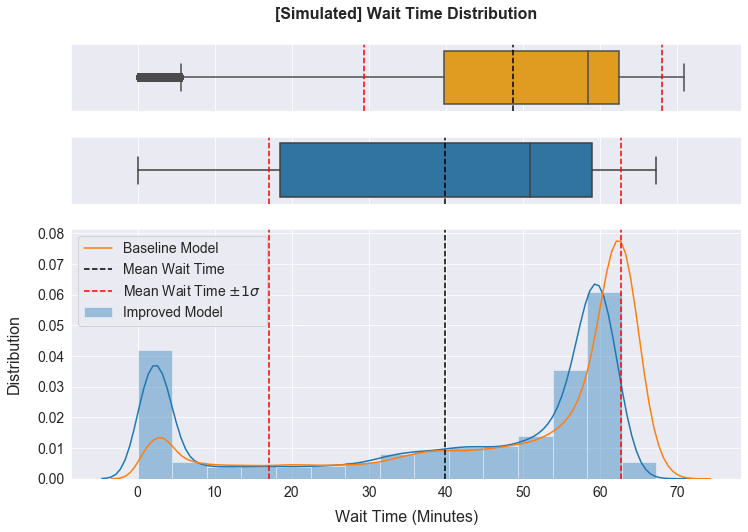

In [128]:
## Plotting Wait Time Distribution ## 

sns.set_style('darkgrid')
fig3a, (ax_box_base, ax_box_new, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.175,.175, .65)}, figsize = (12,8))
plt.title('[Simulated] Wait Time Distribution', fontsize = 16, pad = 210, fontweight = 'semibold')

avg = df['wait'].mean()
std = df['wait'].std()

avg2 = df2['wait'].mean()
std2 = df2['wait'].std()

sns.distplot(df['wait'], hist = True, bins = 15, kde = True, label = 'Improved Model', ax = ax_hist)
sns.distplot(df2['wait'], hist = False, bins = 15, kde = True, label = 'Baseline Model', ax = ax_hist)

sns.boxplot(df['wait'], ax = ax_box_new)
sns.boxplot([df2['wait']], ax = ax_box_base, color = 'orange', labels = ['Baseline Model'])

ax_box_base.set(xlabel='')
ax_box_new.set(xlabel='')

ax_hist.axvline(avg, c = 'k', linestyle = 'dashed', label = 'Mean Wait Time')
ax_hist.axvline(avg + std, c = 'r', linestyle = 'dashed', label = 'Mean Wait Time $ \pm 1 \sigma$')
ax_hist.axvline(avg - std, c = 'r', linestyle = 'dashed')
ax_box_base.axvline(avg2,       c = 'k', linestyle = 'dashed')
ax_box_base.axvline(avg2 + std2, c = 'r', linestyle = 'dashed')
ax_box_base.axvline(avg2 - std2, c = 'r', linestyle = 'dashed')
ax_box_new.axvline(avg,       c = 'k', linestyle = 'dashed')
ax_box_new.axvline(avg + std, c = 'r', linestyle = 'dashed')
ax_box_new.axvline(avg - std, c = 'r', linestyle = 'dashed')

plt.xlabel('Wait Time (Minutes)', fontsize = 16, labelpad = 10)
plt.ylabel('Distribution', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig3a.savefig('fig3a.pdf')

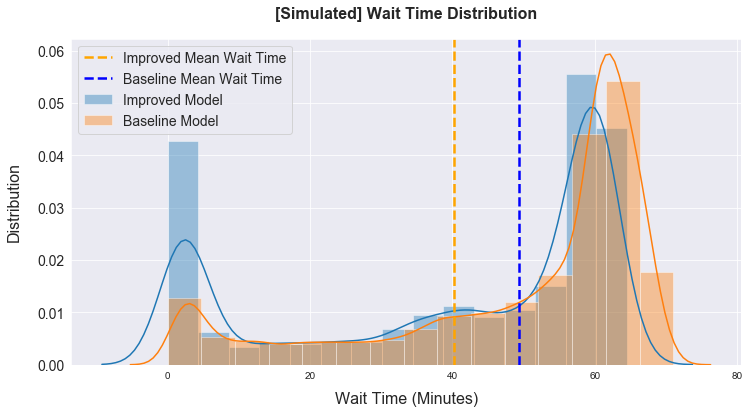

In [10]:
## Plotting Wait Time Distribution ## 

sns.set_style('darkgrid')
fig3a, ax3a = plt.subplots(figsize = (12, 6))

sns.distplot(df['wait'], hist = True, bins = 15, kde = True, label = 'Improved Model')
sns.distplot(df2['wait'], hist = True, bins = 15, kde = True, label = 'Baseline Model')
ax3a.axvline(df['wait'].mean(), c = 'orange',linestyle = 'dashed', lw = 2.5, label = 'Improved Mean Wait Time')
ax3a.axvline(df2['wait'].mean(), c = 'blue',linestyle = 'dashed', lw = 2.5, label = 'Baseline Mean Wait Time')

plt.title('[Simulated] Wait Time Distribution', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Wait Time (Minutes)', fontsize = 16, labelpad = 10)
plt.ylabel('Distribution', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14);
plt.legend(prop={'size': 14})
fig3a.savefig('fig3a.pdf')

___

## Average Wait Times w/ Model #2 Baseline

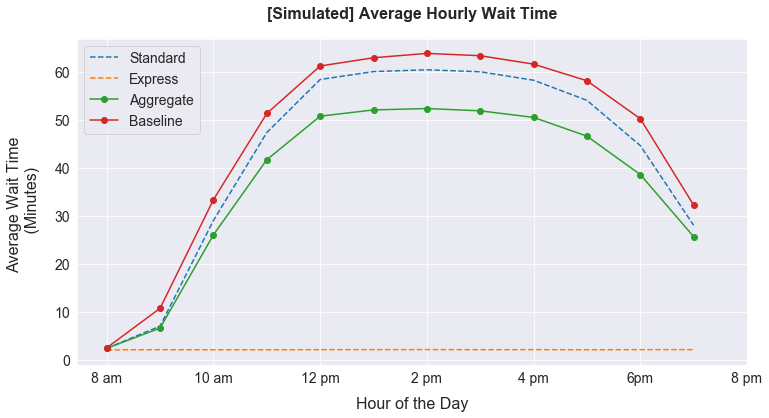

In [129]:
## Plotting Average Wait Time vs Time of Day ## 

standard_df2 = standard_df.groupby('arrival hour')[['wait']].mean()
express_df2 = express_df.groupby('arrival hour')[['wait']].mean()
agg_df2 = df.groupby('arrival hour')[['wait']].mean()
df2_plot = df2.groupby('arrival hour')[['wait']].mean()

sns.set_style('darkgrid')
fig3b, ax3b = plt.subplots(figsize = (12, 6))

plt.plot(standard_df2.index, standard_df2['wait'], linestyle = 'dashed', label = 'Standard')
plt.plot(express_df2.index, express_df2['wait'], linestyle = 'dashed', label = 'Express')
plt.plot(agg_df2.index, agg_df2['wait'], marker = 'o', label = 'Aggregate')
plt.plot(df2_plot.index, df2_plot['wait'], marker = 'o', label = 'Baseline')
#plt.scatter(df.groupby('arrival hour').mean()['wait'].argmax(), df.groupby('arrival hour').mean()['wait'].max(), marker = 'o' , s = 100, c = 'r', label = 'Peak Aggregate Wait Time')

plt.title('[Simulated] Average Hourly Wait Time', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Hour of the Day', fontsize = 16, labelpad = 10)
plt.ylabel('Average Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.xticks([0,2,4,6,8,10,12], ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm', '8 pm'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(prop={'size': 14}, loc = 'upper left')
fig3b.savefig('fig3b.pdf')

In [135]:
print(np.std(express_df['wait']))
print(np.std(standard_df['wait']))

1.2221985353332214
19.085775123828753


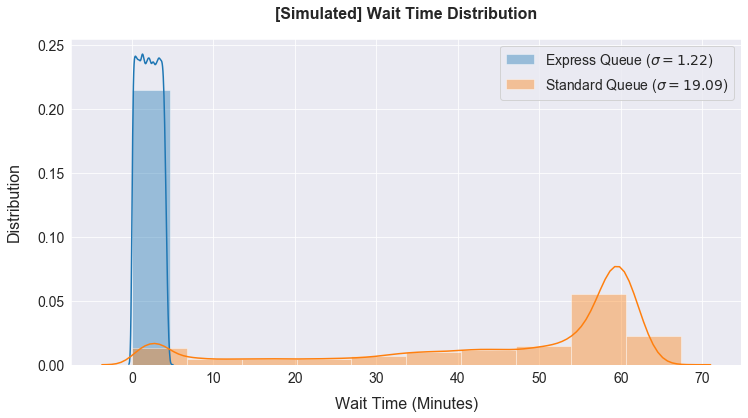

In [139]:
sns.set_style('darkgrid')
fig3c, ax3c = plt.subplots(figsize = (12, 6))

sns.distplot(express_df['wait'], bins = 1, label = 'Express Queue ($\sigma = 1.22$)')
sns.distplot(standard_df['wait'], bins = 10, label = 'Standard Queue ($\sigma = 19.09$)')


plt.title('[Simulated] Wait Time Distribution', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Wait Time (Minutes)', fontsize = 16, labelpad = 10)
plt.ylabel('Distribution', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig3c.savefig('fig3c.pdf')